# Inference pipeline

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export 
from xview2comp.nb_03 import *

### Pre-disaster and post-disaster image file paths

In [3]:
SOURCE = Path('data/test/images')
SOURCE.ls()[:3]

[PosixPath('data/test/images/test_pre_00214.png'),
 PosixPath('data/test/images/test_pre_00572.png'),
 PosixPath('data/test/images/test_post_00619.png')]

In [4]:
preimgs = pre_img_fpaths(get_image_files(SOURCE))

In [5]:
posimgs = [pre2post_fpath(o) for o in preimgs]

In [6]:
len(preimgs), len(posimgs)

(933, 933)

In [7]:
preimgs[:3]

[PosixPath('data/test/images/test_pre_00214.png'),
 PosixPath('data/test/images/test_pre_00572.png'),
 PosixPath('data/test/images/test_pre_00566.png')]

In [8]:
posimgs[:3]

[PosixPath('data/test/images/test_post_00214.png'),
 PosixPath('data/test/images/test_post_00572.png'),
 PosixPath('data/test/images/test_post_00566.png')]

### Building detection

In [9]:
def get_seg_learner():
    sz_seg, bs = 1024, 2

    SOURCE_TRN = Path('data/train/images/')
    trn_preimgs = pre_img_fpaths(get_image_files(SOURCE_TRN))
    codes = np.array(['Empty', 'Building'])
    val_idx = get_random_val_idx(len(trn_preimgs))

    src = (SegItemListCustom(trn_preimgs)
           .split_by_idx(val_idx)
           .label_from_func(img2bmask_fpath, classes=codes))
    tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=.3)
    data = (src.transform(tfms, size=sz_seg, tfm_y=True)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

    metrics = [dice_loss, accuracy_thresh, dice]
    learn = unet_learner(data, models.resnet34, metrics=metrics)
    learn.loss_func = combo_loss
    return learn

In [10]:
%%time
seglearn = get_seg_learner()

CPU times: user 12.6 s, sys: 1.95 s, total: 14.6 s
Wall time: 14.6 s


In [11]:
seglearn.load('sz1024_bs2_resnet34_comboloss_1epochcycle_maxlr1e-3');

In [12]:
seglearn.model.eval();

In [98]:
idx = 818 # 1, 2, 3
#idx = 67 #all undamaged  
#idx = 34 #no features

In [99]:
img = open_image(preimgs[idx])

In [100]:
%%time
bmask, _, _ = seglearn.predict(img)

CPU times: user 14 s, sys: 1.87 s, total: 15.9 s
Wall time: 16.5 s


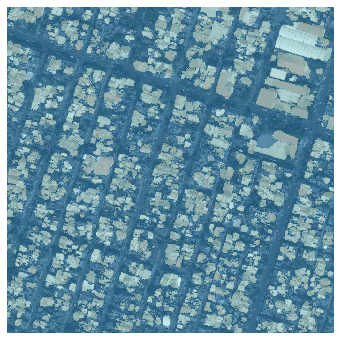

In [101]:
_, ax = plt.subplots(figsize=(6, 6))
img.show(ax)
bmask.show(ax, alpha=.6)

### Building mask -> polygons

In [102]:
_, polys = bmask2polys(bmask.data[0].numpy())

In [103]:
type(polys), len(polys)

(numpy.ndarray, 4764)

### Generate unique ids for polygons

In [104]:
#export
def generate_uid_polys(polys): return np.array([str(uuid4()) for _ in polys])

In [105]:
uids = generate_uid_polys(polys)

### Get polygon images

In [106]:
img = open_image(posimgs[idx])

In [107]:
shutil.rmtree(Path('tmp_inference'), ignore_errors=True)
os.makedirs(Path('tmp_inference'), exist_ok=True)

In [108]:
for uid, p in zip(uids, polys):
    polyimg = crop_by_polygon(img, p)
    polyimg.save(Path('tmp_inference')/f'{uid}.png')

In [109]:
len(Path('tmp_inference/').ls())

4764

### Damage classification

In [88]:
def get_classifier():
    annots = pd.read_csv('class_labels_tiny.csv')
    annots = combine_nodamage_unclassified(annots)
    fnames = [Path('data/train/classification_images')/f'{o}.png' for o in annots.uid]
    val_idx = get_random_val_idx(len(fnames))
    cats = list(annots.damage.value_counts().index)
    src = (ImageList(fnames)
           .split_by_idx(val_idx)
           .label_from_func(partial(get_label, annots), classes=cats))

    bs, sz = 8, 512
    tfms = get_transforms(flip_vert=True, max_rotate=.2, max_warp=0., max_zoom=1.1, max_lighting=.4)
    data = (src.transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
            .databunch(bs=bs)
            .normalize(imagenet_stats))

    return cnn_learner(data, models.resnet50, metrics=error_rate)

In [89]:
%%time
damglearn = get_classifier()

CPU times: user 1.48 s, sys: 308 ms, total: 1.79 s
Wall time: 1.5 s


In [27]:
damglearn.load('classifier_sz512_bs32_resnet50_stage1');  #'damg_classifier_sz64.pth'); #

In [110]:
preds, pred_classes = [], []
for uid in progress_bar(uids):
    polyimg = open_image(Path('tmp_inference')/f'{uid}.png')
    pred_class, pred_idx, outputs = damglearn.predict(polyimg)
    preds.append(list(to_np(outputs)))
    pred_classes.append(str(pred_class))

KeyboardInterrupt: 

In [91]:
len(pred_classes), len(uids), len(polys), img

(158, 158, 158, Image (3, 1024, 1024))

### Damage mask

In [92]:
dmgmask = np.zeros(img.shape[1:], dtype=np.uint8)

In [52]:
dmg_otoi = {dmg:i + 1 for i, dmg in enumerate(damglearn.data.classes)}

In [93]:
for dmg, poly in zip(pred_classes, polys):
    cv2.fillPoly(dmgmask, poly[None,...], (dmg_otoi[dmg]))

In [94]:
dmgmask = ImageSegment(tensor(dmgmask[None,...]))

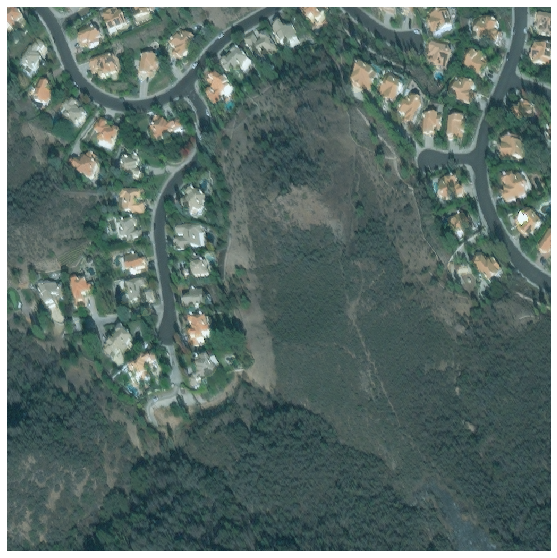

In [97]:
_, ax = plt.subplots(figsize=(10, 10))
img.show(ax)
dmgmask.show(ax, alpha=.2)

# - fin

In [279]:
! python notebook2script.py 03b_inference_pipeline.ipynb

Converted 03b_inference_pipeline.ipynb to xview2comp/nb_03b.py
